
# Imports

In [2]:
########################## EDA
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
#import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

C:\Users\asus\anaconda3\envs\school\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read data

In [3]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
  
df_valid = df.drop(df_train.index)

print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 20000
Number of documents in validation data: 5000


In [4]:
df_train.head()

,review,sentiment
7617,"I have never known of a film to arouse such debate in my life. Believe me when i say that this film will eventually be remembered as an all-time classic. I was waiting in anticipation for this film as i had previously loved both Lock, Stock.... and Snatch, but after some of the negative reviews i thought i would be very disappointed. I absolutely loved this film and i can't wait to see it again. This film is totally different to both of the aforementioned Ritchie films, and also a lot better. I have my pick of favourite directors but none of them have pulled off a move as great as Guy Ritchie has just done with this movie. I believe he has taken movie-making to another level ( i know most people will be laughing at this comment guaging the reaction to this film, but i believe time will prove me right ). This movie is very confusing and carried on for much longer than the 2hr or so running time as i couldn't stop thinking about it or trying to piece things together. I have now got a pretty good take on everything that happens in this film ( some answers from endless hours of thinking, some answers from reading other people's take on the film )and now cannot wait until Sunday when i will see it again. I just hope people go to the cinema with an open mind and they will hopefully be rewarded as i and many others have been.",0
16169,"Oh, for crying out loud, this has got to be the LAMEST movie I've seen all year, and I'm sorry the normally awesome John Cusack was even involved in this brainless, twitty piece of Stupidity. Where Sleepless in Seattle delivered what amounts to be the same message, albeit on a more subtle, somewhat more mature level, Serendipity delivers it with a sledgehammer, and then proceeds to pound it into your psyche for the next tedious hour and a half or so (and that's an hour and a half of my life I'll never get back again, thank you very much!!). It's bad enough the main characters of this movie have the emotional maturity level of fourteen-year-olds (actually I've known better fourteen-year-olds...), except maybe for Jeremy Piven, who was enjoyable enough. Just the first 15 minutes or so of the movie where Kate Beckinsale's character plays that annoying silliness of a game about throwing all sensibility to the wind (literally) had my best friend and I irritated beyond belief. I told my husband Rockstar had more intelligence, and at least, the characters in Rockstar weren't half as dysfunctional as the idiots were in this ""Serendipitous"" mess. It's annoying to watch protagonists who seem to have no clue about choice in their lives, and feel they're nothing more than puppets to destiny and the whims of fate. How utterly tiresome. I'm sure this movie will be more likely enjoyed by those who'd rather not engage in the chaotic messiness of making more complex life choices and then responsibly living with the consequences. After all, here's a movie where our hero and heroine live happily ever after only after wreaking havoc and misery on two other people's lives (namely their respective fiancées), not to mention other relatives and friends, just to get there.",1
15497,"Thanks to some infamous home video distributor who brought in the so called German Independent Series, Four For Venice is not only awful, but really awful. So awful, that i have it dumped at the second hand goods store for extra cash. Nick and Charlotte is a married couple who reached an agreement of having sex only on Tuesday due to their hectic schedule of their profession. Eva and Luis is a pair of couple living from hand to mouth, where Eva works as a waitress and Luis, an artist. Nick indirectly causes Eva to lose her job as an waitress. Luis and Charlotte had an affair at the back of Eva and Nick. Luis cheated on Eva by lying to her that he would be flying off to London to do something related to his artwork, but the fact is, he is flying off to Venice with Charlotte for an adultery holiday. Eva kidnapped Nick and dr

# EDA
### Target

C:\Users\asus\anaconda3\envs\school\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

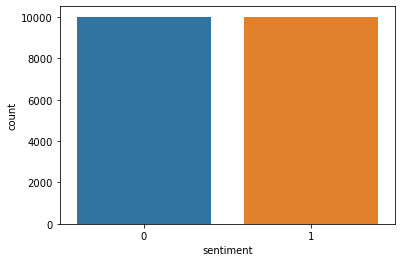

In [5]:
sb.countplot(df_train['sentiment'])

### Text

In [6]:
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

CPU times: total: 24.3 s
Wall time: 24.9 s


Text(0.5, 1.0, 'Negative')

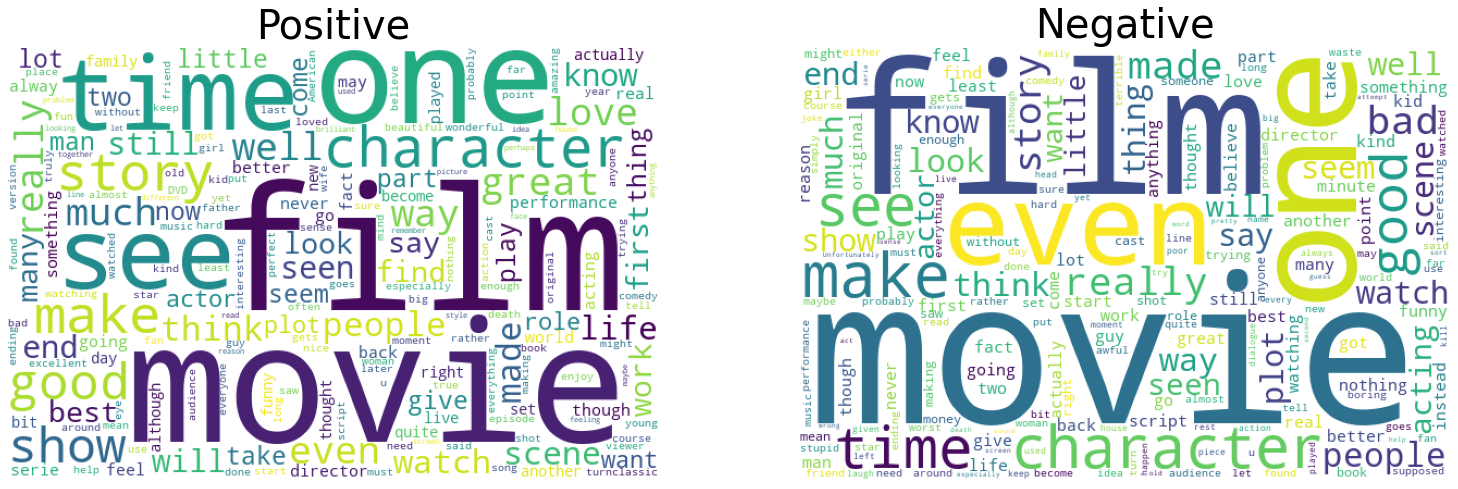

In [7]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [8]:
texts = [
    'Hello this is an sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [9]:
# create a CountVectorizer instance
# fit tranform the text with it
# get the features+

bow =  CountVectorizer()
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,1,0,1,1,0,1,1
Text 2,0,1,1,1,0,1,1
Text 3,0,0,3,1,1,0,1


### Bag Of Words (BOW) + ngram

In [10]:
#do the same approach but using a range in the count vectorizer
bow =  CountVectorizer(ngram_range=(1,2))
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,an sentence,another,another sentence,hello,hello hello,hello this,is,is an,is another,is mellow,mellow,sentence,this,this is
Text 1,1,1,0,0,1,0,1,1,1,0,0,0,1,1,1
Text 2,0,0,1,1,1,0,1,1,0,1,0,0,1,1,1
Text 3,0,0,0,0,3,2,1,1,0,0,1,1,0,1,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [11]:
#Same approach for the TfidfVectorizer
tfidf = TfidfVectorizer()
texts_tfidf = tfidf.fit_transform(texts)
tokens = tfidf.get_feature_names()
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,0.617227,0.000000,0.364544,0.364544,0.000000,0.469417,0.364544
Text 2,0.000000,0.617227,0.364544,0.364544,0.000000,0.469417,0.364544
Text 3,0.000000,0.000000,0.805627,0.268542,0.454682,0.000000,0.268542


# <center> Apply to the reviews

### Bag Of Words 1-gram

In [12]:
x_train, x_valid, y_train, y_valid = df_train['review'], df_valid['review'], df_train['sentiment'], df_valid['sentiment']

In [13]:
x_train.shape

(20000,)

In [14]:
%%time
bow_1gram = CountVectorizer()

train_bow_1gram = bow_1gram.fit_transform(x_train)
valid_bow_1gram = bow_1gram.transform(x_valid)

CPU times: total: 6 s
Wall time: 6.02 s


### Bag Of Words 1-2-grams

In [15]:
%%time
bow_2grams = CountVectorizer(ngram_range=(1,2))
train_bow_2grams = bow_2grams.fit_transform(x_train)
valid_bow_2grams = bow_2grams.transform(x_valid)

CPU times: total: 20.2 s
Wall time: 20.5 s


### TFIDF 1-gram

In [16]:
%%time
tfidf_1gram       = TfidfVectorizer()
train_tfidf_1gram = tfidf_1gram.fit_transform(x_train)
valid_tfidf_1gram = tfidf_1gram.transform(x_valid)

CPU times: total: 7.19 s
Wall time: 7.33 s


### TFIDF 1-2-grams

In [17]:
%%time
tfidf_2grams      = TfidfVectorizer(ngram_range=(1,2))
train_tfidf_2grams = tfidf_2grams.fit_transform(x_train)
valid_tfidf_2grams = tfidf_2grams.transform(x_valid)

CPU times: total: 22.5 s
Wall time: 22.7 s


In [18]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (20000, 68335)
BOW 2grams   (20000, 1291564)
TFIDF 1gram  (20000, 68335)
TFIDF 2grams (20000, 1291564)


# <center> ML Models

## Naive Bayes (<1 s)

In [19]:
mlnb = MultinomialNB()
for name, x_train, x_valid in data:
    
    #Train a MultinomialNB model and meassure the time
    tt = time.time()
    mlnb.fit(x_train,y_train)
    t = time.time()-tt
    a = accuracy_score(y_valid, mlnb.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8556 	Time:	 0.03792715072631836
BOW 2grams 	Accuracy:	 0.883 	Time:	 0.304243803024292
TFIDF 1gram 	Accuracy:	 0.868 	Time:	 0.029918432235717773
TFIDF 2grams 	Accuracy:	 0.8888 	Time:	 0.23238086700439453


## Logistic Regression (30s)

In [22]:
clf =LogisticRegression(max_iter=1500)
for name, x_train, x_valid in data:
    #Train a LogisticRegression model and meassure the time
    tt = time.time()
    clf.fit(x_train,y_train)
    t = time.time()-tt
    a = accuracy_score(y_valid, clf.predict(x_valid))

    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8742 	Time:	 16.57507848739624
BOW 2grams 	Accuracy:	 0.8954 	Time:	 151.5589623451233
TFIDF 1gram 	Accuracy:	 0.8856 	Time:	 2.3955962657928467
TFIDF 2grams 	Accuracy:	 0.885 	Time:	 23.00411820411682


## Random Forest (10+90+6+22 seconds)

In [23]:
rnd_model = RandomForestClassifier()
for name, x_train, x_valid in data:
    tt  = time.time()
    rnd_model.fit(x_train,y_train)
    t = time.time()-tt
    #Train a RandomForestClassifier model and meassure the time
    a = accuracy_score(y_valid, rnd_model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8376 	Time:	 47.12731957435608
BOW 2grams 	Accuracy:	 0.8476 	Time:	 223.35180568695068
TFIDF 1gram 	Accuracy:	 0.8292 	Time:	 40.61769914627075
TFIDF 2grams 	Accuracy:	 0.8438 	Time:	 203.94545984268188
